# Linear Regression for feature ranking

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler
import os
# change to your local path to project below
project_path = '/home/jorge/Insync/jorgitoje@gmail.com/OneDrive/Documentos/JORGE/EDUCATION/MASTER_DATASCIENCE/Semester1/AdvancedStatistics/GroupProject/KDS_Statistics_GroupProject'

In [2]:
dataset_basepath = os.path.join(project_path, 'datasets')
datasets = {
    'USA_houseprices_2014':['USA_houseprices_2014/preprocessed_data_USAhouseprices2014.csv','price'],
    'Bike_sharing': ['Bike Sharing/preprocessed_hour.csv','cnt'], 
    'Airbnb_price': ['Airbnb_price/data_Airbnb_preprocessed.csv','log_price'], 
    'austin_housing': ['austin_housing/processed_austin_housing.csv','latestPrice'] , 
    'cars': ['cars/New_cars_preprocessed.csv','MSRP']
}

for dataset_name, dataset_metadata in datasets.items():
    
    data = pd.read_csv(os.path.join(dataset_basepath, dataset_metadata[0]))
    dataset_metadata.append(data)


In [3]:
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

## Fitting of models + Rank creation for all datasets

In [11]:
all_ranks_all_datasets = pd.DataFrame()
coefficients = {}

for dataset_name, dataset_metadata in datasets.items():

    data = dataset_metadata[2]
    # MODEL FITTING ------------------------------------------------------------
    X = data.copy(deep=True)
    y = X.pop(dataset_metadata[1])
    features_names = X.columns

    # Define dictionary to store our rankings
    ranks = {}

    lr = LinearRegression()
    lr.fit(X,y)
    ranks["Linear_regression"] = ranking(np.abs(lr.coef_), features_names)

    # print ("Linear model:", pretty_print_linear(lr.coef_))

    # Using Ridge 
    ridge = Ridge(alpha = 7)
    ridge.fit(X,y)
    ranks['Ridge_regression'] = ranking(np.abs(ridge.coef_), features_names)
    # print ("Ridge model:", pretty_print_linear(ridge.coef_))

    # Using Lasso
    lasso = Lasso(alpha=.005)
    lasso.fit(X,y)
    ranks["Lasso_regression"] = ranking(np.abs(lasso.coef_), features_names)
    # print ("Lasso model:", pretty_print_linear(lasso.coef_))

    coefficients[dataset_name] = {"features_names":features_names, "Linear_regression": lr.coef_, 'Ridge_regression':ridge.coef_,
     "Lasso_regression":lasso.coef_}
    methods_names = [ key for key in ranks.keys()]

    # RANK CALCULATION --------------------------------------------------------
    
    decimalrank_df = pd.DataFrame()

    # Join preranks in dataframe
    for method_name, rank_list in ranks.items():
        df_Temp = pd.DataFrame(data = {method_name:pd.Series(rank_list)})
        decimalrank_df = pd.concat([decimalrank_df,df_Temp ], axis=1)

    rank_df = pd.DataFrame()
    # Create new integer ranks
    for method_name, rank_list in ranks.items():
        rank_df[method_name] = decimalrank_df[method_name].rank(ascending=False)

    rank_df['feature_name'] = rank_df.index
    dataset_metadata.append(rank_df)

    ranksout = rank_df.melt(id_vars = 'feature_name', var_name='method', value_name='feature_rank')
    ranksout['dataset'] = dataset_name
    ranksout = ranksout[ranksout['method'].isin(methods_names)]

    all_ranks_all_datasets = pd.concat([all_ranks_all_datasets, ranksout], axis=0)


## Saving ranks 

In [12]:
all_ranks_all_datasets.to_csv(os.path.join(project_path, 'data', 'featureranks_linear.csv'), sep=";", index=False)

## Reporting of results

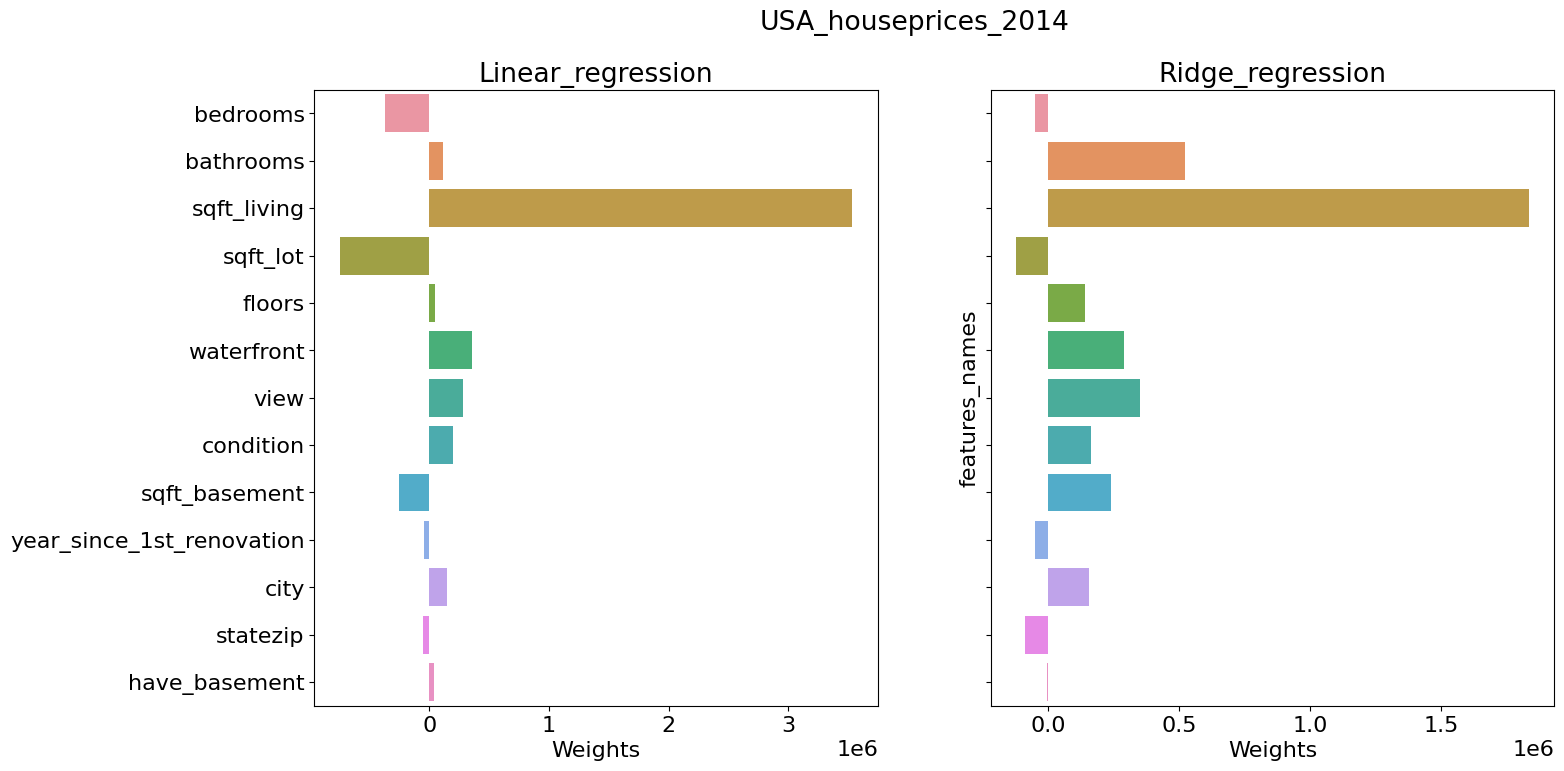

In [36]:
# For one dataset only
data = pd.DataFrame(coefficients['USA_houseprices_2014'])

data
plt.rcParams.update({'font.size': 16})
plt.rcParams['lines.linewidth'] = 1.2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), sharey=True)
fig.suptitle('USA_houseprices_2014')

sns.barplot(ax=ax1, x="Linear_regression", y="features_names",  data=data)
ax1.set_title("Linear_regression")

sns.barplot(ax=ax2, x="Ridge_regression", y="features_names",  data=data)
ax2.set_title('Ridge_regression')

ax1.set_xlabel("Weights")
ax2.set_xlabel("Weights")
ax1.set(ylabel=None)

fig.savefig(os.path.join(project_path, 'img',"linearregressionweights_barplot.png"), dpi=200, bbox_inches='tight' )